## Analyze Learning Curves

1. Find a comparable checkpoints between two trainings.
    + Either statistically
    + or ...
2. 

In [1]:
import pickle
from scipy import stats
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme();

import numpy as np
import nibabel as nib

import torch
import torch.nn.functional as F

from sage.visualization.vistool import plot_vismap
from utils.analysis import Result, FileSelector, check_existence, cherry_picker, transform

/opt/conda/envs/research/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [59]:
with open("./data/naive_results.pkl", "rb") as f:
# with open("./data/naive_nonreg_results.pkl", "rb") as f:
    naive_results = pickle.load(f)
    naive_results = {e[0]: e[1] for e in sorted(naive_results.items(), key=lambda x: x[0])}
    
with open("./data/augment_results.pkl", "rb") as f:
# with open("./data/augment_nonreg_results.pkl", "rb") as f:
    augment_results = pickle.load(f)
    augment_results = {e[0]: e[1] for e in sorted(augment_results.items(), key=lambda x: x[0])}

In [60]:
naive = Result(naive_results)
augment = Result(augment_results)

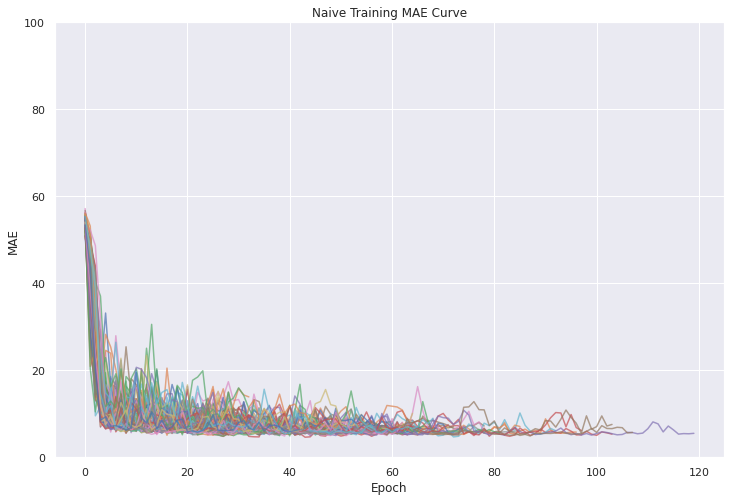

In [4]:
plt.figure(figsize=(12, 8))
plt.title("Naive Training MAE Curve")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.ylim(0, 100)

for idx in range(len(naive)):
    plt.plot(*transform(naive[idx]), alpha=.7)

plt.show();

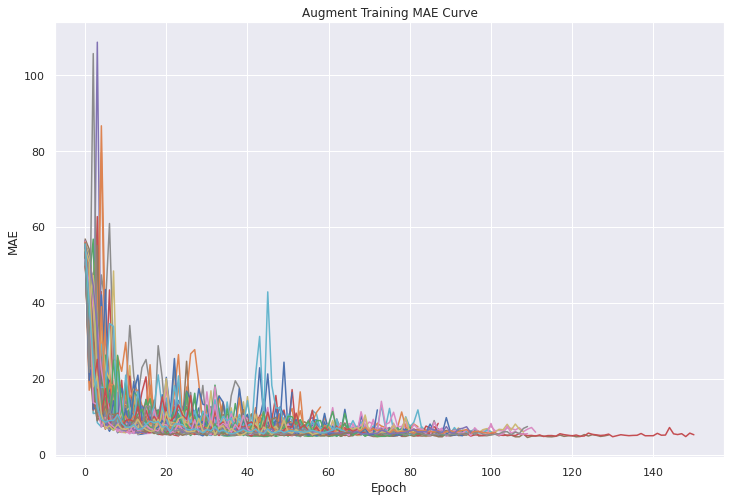

In [61]:
plt.figure(figsize=(12, 8))
plt.title("Augment Training MAE Curve")
plt.xlabel("Epoch")
plt.ylabel("MAE")

for idx in range(len(augment)):
    plt.plot(*transform(augment[idx]))

plt.show();

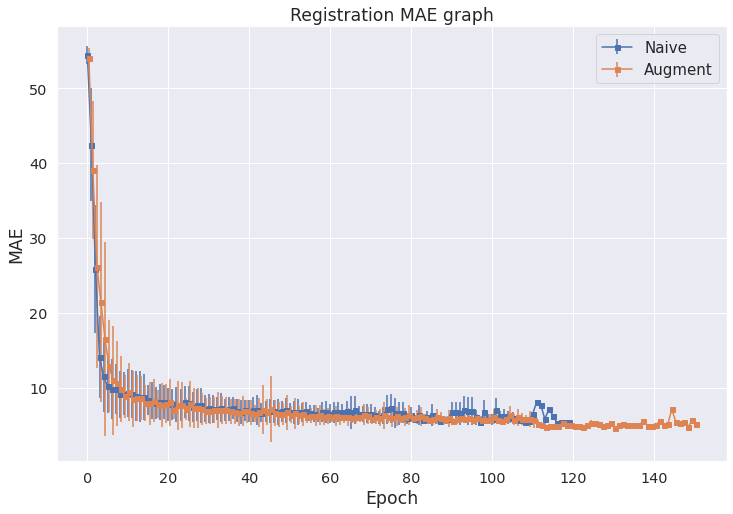

In [62]:
plt.figure(figsize=(12, 8))
plt.title("Registration MAE graph", size="x-large")
plt.xlabel("Epoch", size="x-large")
plt.ylabel("MAE", size="x-large")
plt.xticks(fontsize="large")
plt.yticks(fontsize="large")
plt.errorbar(
    *map(list, (naive.mean.keys(), naive.mean.values())), ms=5, marker='s',
    yerr=list(naive.std.values()), label="Naive"
);
plt.errorbar(
    np.array(list(augment.mean.keys())) + .35, list(augment.mean.values()), ms=5, marker='s',
    yerr=list(augment.std.values()), label="Augment"
);
plt.legend(prop={"size": 15})
plt.savefig("figs/reg_dpi.png", dpi=1200, bbox_inches='tight', pad_inches=0)

In [63]:
last_values_naive = [e[-1][1] for e in naive.raw_data.values()]
last_values_augment = [e[-1][1] for e in augment.raw_data.values()]

stats.ttest_ind(last_values_naive, last_values_augment)

Ttest_indResult(statistic=1.0990587789525672, pvalue=0.2730703078217951)

In [64]:
best_values_naive = [min(_[1] for _ in e) for e in naive.raw_data.values()]
best_values_augment = [min(_[1] for _ in e) for e in augment.raw_data.values()]

stats.ttest_ind(best_values_naive, best_values_augment)

Ttest_indResult(statistic=2.879221535304477, pvalue=0.004422656227491631)

In [65]:
earlystopped_values_naive = [e[-20][1] for e in naive.raw_data.values()]
earlystopped_values_augment = [e[-20][1] for e in augment.raw_data.values()]

stats.ttest_ind(earlystopped_values_naive, earlystopped_values_augment)

Ttest_indResult(statistic=-0.2240422043460316, pvalue=0.8229543123500607)

In [66]:
total_train_naive = [len(e) for e in naive.raw_data.values()]
total_train_augment = [len(e) for e in augment.raw_data.values()]

stats.ttest_ind(total_train_naive, total_train_augment)

Ttest_indResult(statistic=-4.5232628815038405, pvalue=1.0454025106861184e-05)

In [67]:
best_indices_naive = [sorted(e, key=lambda x: x[1])[0][0] for e in naive.raw_data.values()]
best_indices_augment = [sorted(e, key=lambda x: x[1])[0][0] for e in augment.raw_data.values()]

stats.ttest_ind(best_indices_naive, best_indices_augment)

Ttest_indResult(statistic=-4.595285554815261, pvalue=7.664566425511195e-06)

In [132]:
naive_fileselector = FileSelector("naive")
best_maps_naive = np.array(list(map(
    partial(cherry_picker, selector=naive_fileselector), 
    list(filter(\
        partial(check_existence, selector=naive_fileselector), \
        zip(range(len(best_indices_naive)), best_indices_naive))
))))

42 46


In [133]:
augment_fileselector = FileSelector("augment")
best_maps_augment = np.array(list(map(
    partial(cherry_picker, selector=augment_fileselector), 
    list(filter(\
        partial(check_existence, selector=augment_fileselector), \
        zip(range(len(best_indices_augment)), best_indices_augment))
))))

In [21]:
def parser(input, selector):

    fname = selector.get("npy_std/layer0", input[0])[input[1]]
    return " ".join((fname.split("/")[1], fname.split("/")[5]))

In [22]:
meta = list(map(
    partial(parser, selector=naive_fileselector),
    zip(range(len(best_indices_naive)), best_indices_naive)
))

In [140]:
best_maps_naive.ndim

4

In [141]:
def save2nifti(npy, savename, overwrite=False):
    
    """
    Takes saliency map with shape of (96, 96, 96)
    """
    if npy.ndim == 4:
        print(f"Came across with array dimension of {npy.ndim}, {npy.shape}.")
        print(f"Shrink with average on axis=0")
        npy = np.mean(npy, axis=0)

    # Resize
    resized_nifti = F.interpolate(
        torch.tensor(npy[None, None, ...]), size=(207, 256, 215)
    ).squeeze().squeeze().numpy()

    # Define Affine Matrix
    affine = np.array([
        [.73746, .00000, .00000, -75.76254],
        [.00000, .73746, .00000, -110.76254],
        [.00000, .00000, .73746, -71.76254],
        [0, 0, 0, 0]
    ])

    
    if os.path.exists(savename):
        if overwrite is False:
            print("File with same name exists, please allow overwrite to replace.")
            return

    nib.save(
        nib.Nifti1Image(
            resized_nifti,
            affine,
        ),
        savename
    )
    print("Successfully saved.")

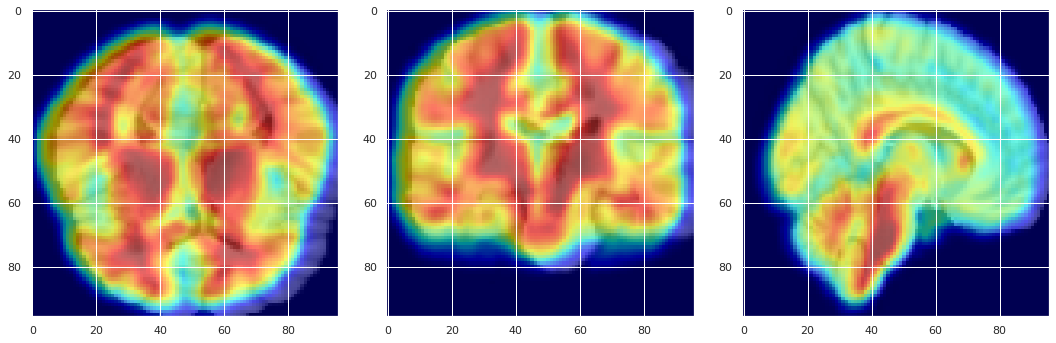

In [134]:
plot_vismap("template", np.mean(best_maps_naive, axis=0), masked=False);

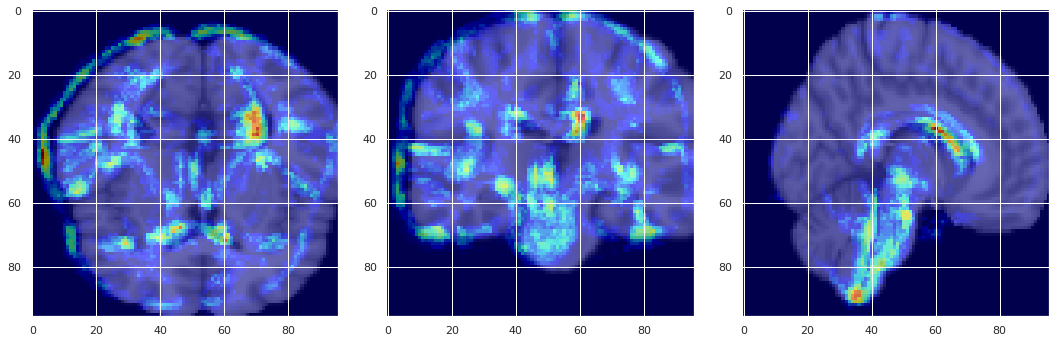

In [135]:
best_maps_naive_thrsh = best_maps_naive.copy()
for idx, npy in enumerate(best_maps_naive):
    thresholded = (npy > np.quantile(npy, 0.99)) * npy
    best_maps_naive_thrsh[idx] = thresholded
plot_vismap("template", np.mean(best_maps_naive_thrsh, axis=0), masked=False);

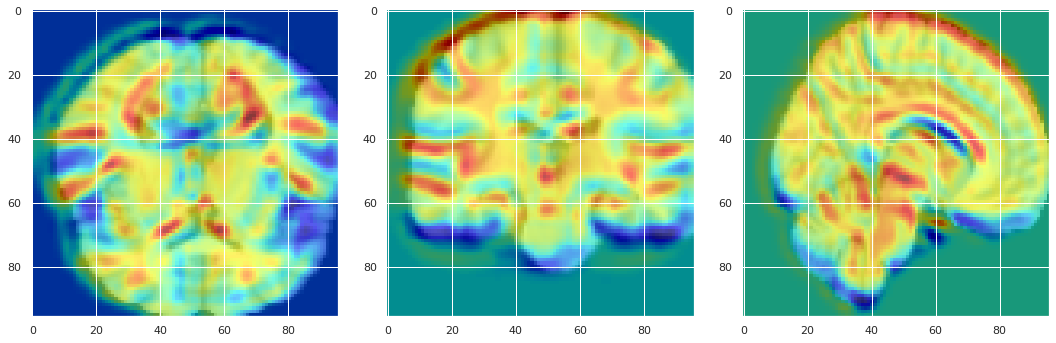

In [136]:
plot_vismap("template", np.mean(best_maps_augment, axis=0), masked=False);

In [144]:
np.quantile(np.mean(best_maps_naive, axis=0), 0.99), np.quantile(np.mean(best_maps_augment, axis=0), 0.99)

(0.2110256351530552, 0.1731683239340783)

In [142]:
save2nifti(best_maps_naive, "../miccai2022/best_naive_raw.nii")
save2nifti(best_maps_augment, "../miccai2022/best_aug_raw.nii")

Came across with array dimension of 4, (100, 96, 96, 96).
Shrink with average on axis=0
Successfully saved.
Came across with array dimension of 4, (100, 96, 96, 96).
Shrink with average on axis=0
Successfully saved.


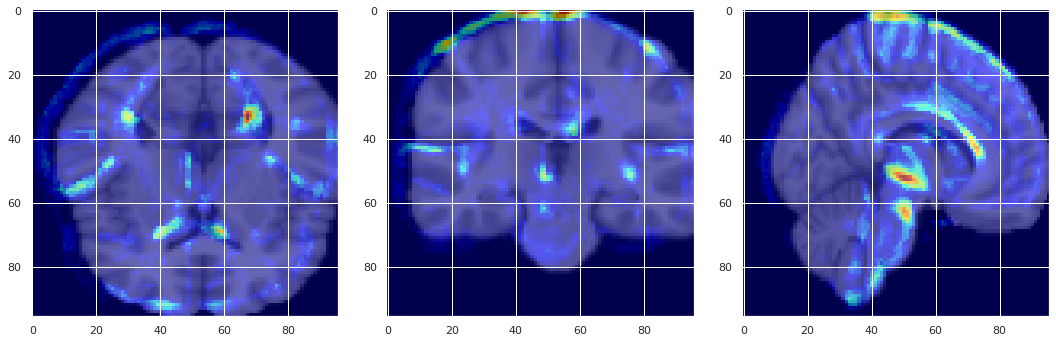

In [137]:
best_maps_augment_thrsh = best_maps_augment.copy()
for idx, npy in enumerate(best_maps_augment):
    thresholded = (npy > np.quantile(npy, 0.99)) * npy
    best_maps_augment_thrsh[idx] = thresholded
plot_vismap("template", np.mean(best_maps_augment_thrsh, axis=0), masked=False);

### Get Test data inferred

In [77]:
from utils.analysis import FileSelector, Result, MAE
import numpy as np
from functools import partial
from scipy import stats
import pickle

naive_sel = FileSelector("naive")
augment_sel = FileSelector("augment")

# naive_sel = FileSelector("naive_nonreg")
# augment_sel = FileSelector("augment_nonreg")

gt_result = np.array(naive_sel.test_gt)

In [19]:
test_reuslt = {
    augment_sel[idx][0].split("/")[2]: list(map(lambda x: (x[0], MAE(gt_result, x[1])), enumerate(augment_sel.get_test_result(idx).values()))) \
        for idx in range(len(augment_sel))
}

In [20]:
from glob import glob 
for idx, date in enumerate(test_reuslt):
    true_epochs = len(glob(f"../resnet256_augmentation_nonreg_checkpoints/{date}/encoder/*.pt"))
    exist_epochs = len(test_reuslt[date])
    if true_epochs == exist_epochs:
        pass
    else:
        print(idx, date)
        print(f"TRUE: {true_epochs}")
        print(f"EXIS: {exist_epochs}\n")

67 20220125-0935_resnet
TRUE: 163
EXIS: 0

95 20220127-0901_resnet
TRUE: 152
EXIS: 150



In [21]:
with open("./data/naive_nonreg_test_results.pkl", "wb") as f:
    pickle.dump(test_reuslt, f)

### Test Result

In [71]:
with open("./data/naive_test_results.pkl", "rb") as f:
    naive_results = pickle.load(f)
    naive_results = {e[0]: e[1] for e in sorted(naive_results.items(), key=lambda x: x[0])}
    
with open("./data/augment_test_results.pkl", "rb") as f:
    augment_results = pickle.load(f)
    augment_results = {e[0]: e[1] for e in sorted(augment_results.items(), key=lambda x: x[0])}

In [47]:
with open("./data/naive_nonreg_test_results.pkl", "rb") as f:
    nonreg_naive_results = pickle.load(f)
    nonreg_naive_results = {e[0]: e[1] for e in sorted(nonreg_naive_results.items(), key=lambda x: x[0])}
    
with open("./data/augment_nonreg_test_results.pkl", "rb") as f:
    nonreg_augment_results = pickle.load(f)
    nonreg_augment_results = {e[0]: e[1] for e in sorted(nonreg_augment_results.items(), key=lambda x: x[0])}

In [72]:
naive = Result(naive_results)
augment = Result(augment_results)

nonreg_naive = Result(nonreg_naive_results)
nonreg_augment = Result(nonreg_augment_results)

In [49]:
# plt.figure(figsize=(12, 8))
# plt.title("Naive Training MAE Curve")
# plt.xlabel("Epoch")
# plt.ylabel("MAE")
# plt.ylim(0, 100)

# for idx in range(len(naive)):
#     plt.plot(*transform(naive[idx]), alpha=.7)

# plt.show();

In [50]:
# plt.figure(figsize=(12, 8))
# plt.title("Augment Training MAE Curve")
# plt.xlabel("Epoch")
# plt.ylabel("MAE")

# for idx in range(len(augment)):
#     plt.plot(*transform(augment[idx]))

# plt.show();

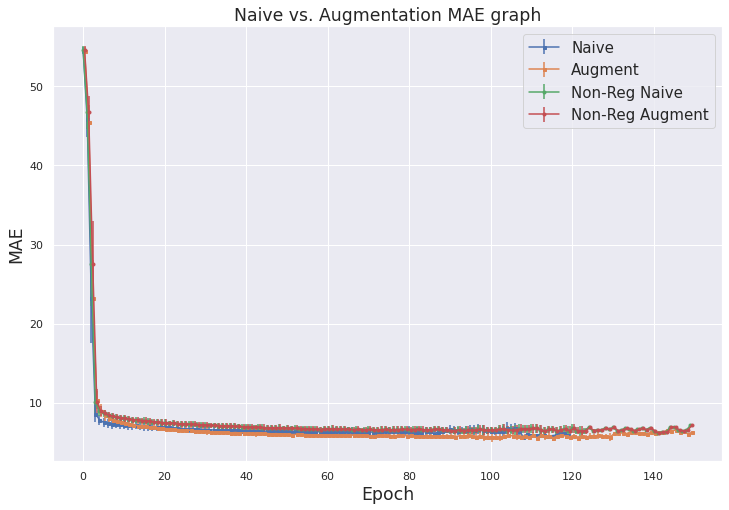

In [51]:
plt.figure(figsize=(12, 8))
plt.title("Naive vs. Augmentation MAE graph", size="x-large")
plt.xlabel("Epoch", size="x-large")
plt.ylabel("MAE", size="x-large")
plt.errorbar(
    *map(list, (naive.mean.keys(), naive.mean.values())), ms=3, marker='s',
    yerr=list(naive.std.values()), label="Naive"
);
plt.errorbar(
    np.array(list(augment.mean.keys())) + .35, list(augment.mean.values()), ms=3, marker='s',
    yerr=list(augment.std.values()), label="Augment"
);

plt.errorbar(
    *map(list, (nonreg_naive.mean.keys(), nonreg_naive.mean.values())), ms=3, marker='o',
    yerr=list(nonreg_naive.std.values()), label="Non-Reg Naive"
);
plt.errorbar(
    np.array(list(nonreg_augment.mean.keys())) + .35, list(nonreg_augment.mean.values()), ms=3, marker='o',
    yerr=list(nonreg_augment.std.values()), label="Non-Reg Augment"
);
plt.legend(prop={"size": 15})

In [52]:
def group_stats(naive, augment, info=None):

    if info:
        print(info)
    print(f"Naive  : {np.mean(naive):.3f} ± {np.std(naive):.3f}")
    print(f"Augment: {np.mean(augment):.3f} ± {np.std(augment):.3f}")
    t_stat, p_val = stats.ttest_ind(naive, augment)
    print(f"Statistics: {t_stat:.2f} p-value: {p_val}\n")

In [94]:
last_values_naive = [e[-1][1] for e in naive.raw_data.values()]
last_values_augment = [e[-1][1] for e in augment.raw_data.values()]

best_values_naive = [min(_[1] for _ in e) for e in naive.raw_data.values()]
best_values_augment = [min(_[1] for _ in e) for e in augment.raw_data.values()]

earlystopped_values_naive = [e[-20][1] for e in naive.raw_data.values()]
earlystopped_values_augment = [e[-20][1] for e in augment.raw_data.values()]

total_train_naive = [len(e) for e in naive.raw_data.values()]
total_train_augment = [len(e) for e in augment.raw_data.values()]

best_indices_naive = [sorted(e, key=lambda x: x[1])[0][0] for e in naive.raw_data.values()]
best_indices_augment = [sorted(e, key=lambda x: x[1])[0][0] for e in augment.raw_data.values()]

In [54]:
group_stats(last_values_naive, last_values_augment, "Last Value")
group_stats(best_values_naive, best_values_augment, "Best Value")
group_stats(earlystopped_values_naive, earlystopped_values_augment, "Early Stopped Value")
group_stats(total_train_naive, total_train_augment, "Total Training Epoch Value")
group_stats(best_indices_naive, best_indices_augment, "Best Indices Value")

Last Value
Naive  : 6.451 ± 0.468
Augment: 5.960 ± 0.374
Statistics: 8.17 p-value: 3.557987080995059e-14

Best Value
Naive  : 5.941 ± 0.351
Augment: 5.657 ± 0.336
Statistics: 5.82 p-value: 2.268213481370538e-08

Early Stopped Value
Naive  : 6.530 ± 0.533
Augment: 6.108 ± 0.474
Statistics: 5.90 p-value: 1.5545621625719326e-08

Total Training Epoch Value
Naive  : 55.337 ± 19.270
Augment: 68.550 ± 21.861
Statistics: -4.52 p-value: 1.0412915581114298e-05

Best Indices Value
Naive  : 42.248 ± 15.829
Augment: 58.000 ± 18.856
Statistics: -6.39 p-value: 1.1838623192270008e-09



In [55]:
del nonreg_augment.raw_data['20220125-0935_resnet']
del nonreg_naive.raw_data['20220125-0935_resnet']

In [56]:
last_values_naive = [e[-1][1] for e in nonreg_naive.raw_data.values()]
last_values_augment = [e[-1][1] for e in nonreg_augment.raw_data.values()]

best_values_naive = [min(_[1] for _ in e) for e in nonreg_naive.raw_data.values()]
best_values_augment = [min(_[1] for _ in e) for e in nonreg_augment.raw_data.values()]

earlystopped_values_naive = [e[-20][1] for e in nonreg_naive.raw_data.values()]
earlystopped_values_augment = [e[-20][1] for e in nonreg_augment.raw_data.values()]

total_train_naive = [len(e) for e in nonreg_naive.raw_data.values()]
total_train_augment = [len(e) for e in nonreg_augment.raw_data.values()]

best_indices_naive = [sorted(e, key=lambda x: x[1])[0][0] for e in nonreg_naive.raw_data.values()]
best_indices_augment = [sorted(e, key=lambda x: x[1])[0][0] for e in nonreg_augment.raw_data.values()]

In [57]:
group_stats(last_values_naive, last_values_augment, "Last Value")
group_stats(best_values_naive, best_values_augment, "Best Value")
group_stats(earlystopped_values_naive, earlystopped_values_augment, "Early Stopped Value")
group_stats(total_train_naive, total_train_augment, "Total Training Epoch Value")
group_stats(best_indices_naive, best_indices_augment, "Best Indices Value")

Last Value
Naive  : 6.680 ± 0.380
Augment: 6.680 ± 0.380
Statistics: 0.00 p-value: 1.0

Best Value
Naive  : 6.380 ± 0.364
Augment: 6.380 ± 0.364
Statistics: 0.00 p-value: 1.0

Early Stopped Value
Naive  : 6.997 ± 0.485
Augment: 6.997 ± 0.485
Statistics: 0.00 p-value: 1.0

Total Training Epoch Value
Naive  : 64.480 ± 25.111
Augment: 64.480 ± 25.111
Statistics: 0.00 p-value: 1.0

Best Indices Value
Naive  : 53.541 ± 21.881
Augment: 53.541 ± 21.881
Statistics: 0.00 p-value: 1.0



In [98]:
naive_fileselector = FileSelector("naive")
best_maps_naive = np.array(list(map(
    partial(cherry_picker, selector=naive_fileselector), 
    list(filter(\
        partial(check_existence, selector=naive_fileselector), \
        zip(range(len(best_indices_naive)), best_indices_naive))
))))

42 46


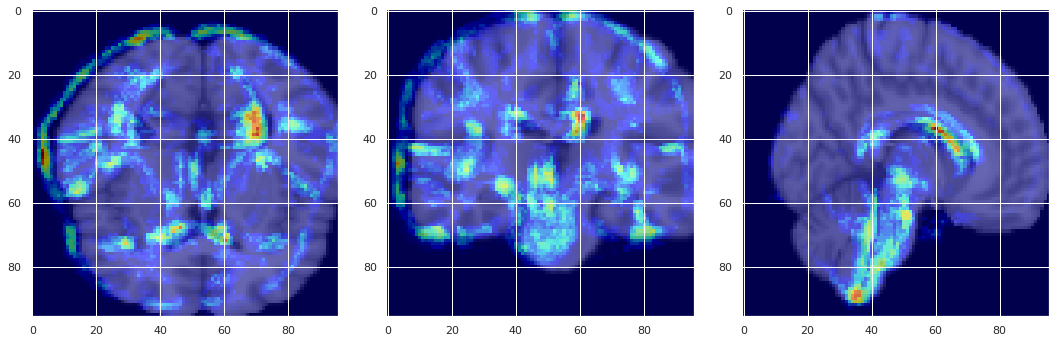

In [99]:
best_maps_naive_copy = best_maps_naive.copy()
for idx, npy in enumerate(best_maps_naive):
    thresholded = (npy > np.quantile(npy, 0.99)) * npy
    best_maps_naive_copy[idx] = thresholded

plot_vismap("template", np.mean(best_maps_naive_copy, axis=0), masked=False);

In [48]:
from nilearn.datasets import load_mni152_template
from skimage.transform import resize

resize_shape=(96, 96, 96)
maxcut=None

In [52]:
brain = load_mni152_template().get_fdata()
maxcut = (
    (
        [8, 82],
            [5, 104],
            [0, 78],
        )
        if maxcut is None
        else maxcut
    )
(w, W), (h, H), (d, D) = maxcut
brain = brain[w:W, h:H, d:D]
brain = resize(brain, resize_shape)
# brain = np.transpose(brain, (1, 2, 0))

In [27]:
import nibabel as nib

img = nib.load("sample.nii").get_fdata()

In [97]:
# SOFT SUM
augment_fileselector = FileSelector("augment")
best_maps_augment = np.array(list(map(
    partial(cherry_picker, selector=augment_fileselector), 
    list(filter(\
        partial(check_existence, selector=augment_fileselector), \
        zip(range(len(best_indices_augment)), best_indices_augment))
))))

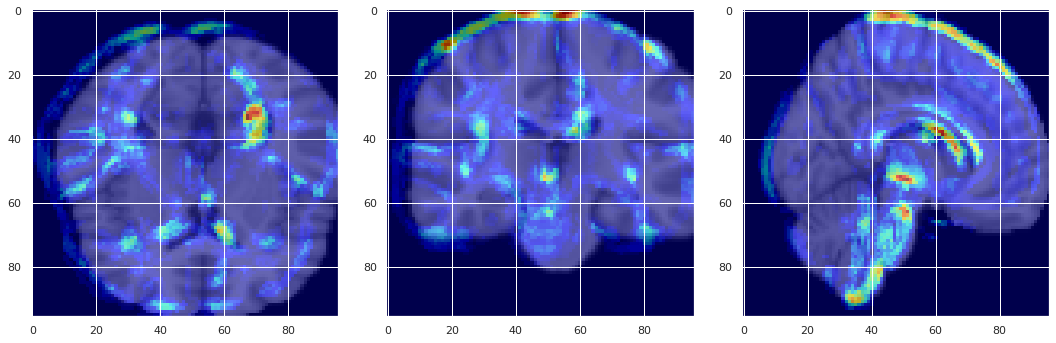

In [96]:
best_maps_augment_copy = best_maps_augment.copy()
for idx, npy in enumerate(best_maps_augment):
    thresholded = (npy > np.quantile(npy, 0.99)) * npy
    best_maps_augment_copy[idx] = thresholded

plot_vismap("template", np.mean(best_maps_augment_copy, axis=0), masked=False);

In [104]:
naive_nifti = np.mean(best_maps_naive_copy, axis=0)
aug_nifti = np.mean(best_maps_augment_copy, axis=0)

In [124]:
overlap = (naive_nifti > np.quantile(naive_nifti, .95)) & (aug_nifti > np.quantile(aug_nifti, .95))
overlap = overlap * (aug_nifti + naive_nifti)

In [107]:
np.quantile(naive_nifti, .95), np.quantile(aug_nifti, .95)

(0.023900355212390423, 0.02727849269285798)

In [125]:
# resized_nifti = F.interpolate(torch.tensor(nifti[None, None, ...]), size=(204, 240, 214)).squeeze().squeeze().numpy()
resized_nifti = F.interpolate(torch.tensor(overlap[None, None, ...]), size=(207, 256, 215)).squeeze().squeeze().numpy()

In [126]:
affine = np.array([
    [.73746, .00000, .00000, -75.76254],
    [.00000, .73746, .00000, -110.76254],
    [.00000, .00000, .73746, -71.76254],
    [0, 0, 0, 0]
])

In [127]:
nib.save(
    nib.Nifti1Image(
        resized_nifti,
        affine,
    ),
    "../miccai2022/overlap_hard.nii"
)

In [25]:
import pandas as pd

labels = pd.read_csv("../non_registered/nifti/label.csv")

In [65]:
import nibabel as nib
import numpy as np
from tqdm import tqdm
for fname in tqdm(labels["abs_path"]):

    nifti = nib.load(fname).get_fdata()
    resized_nifti = F.interpolate(torch.tensor(nifti[None, None, ...]), size=(96, 96, 96)).squeeze().squeeze().numpy()
    npy_fname = fname.replace("nifti", "npy").replace(".nii", ".npy")
    np.save(npy_fname, resized_nifti)
    # break

100%|██████████| 1452/1452 [06:59<00:00,  3.46it/s] 


In [32]:
from scipy import stats

In [34]:
resized_nifti = np.resize(nifti, (96, 96, 96))

In [43]:
import torch
import torch.nn.functional as F

In [50]:
resized_nifti = F.interpolate(torch.tensor(nifti[None, None, ...]), size=(96, 96, 96)).squeeze().squeeze().numpy()

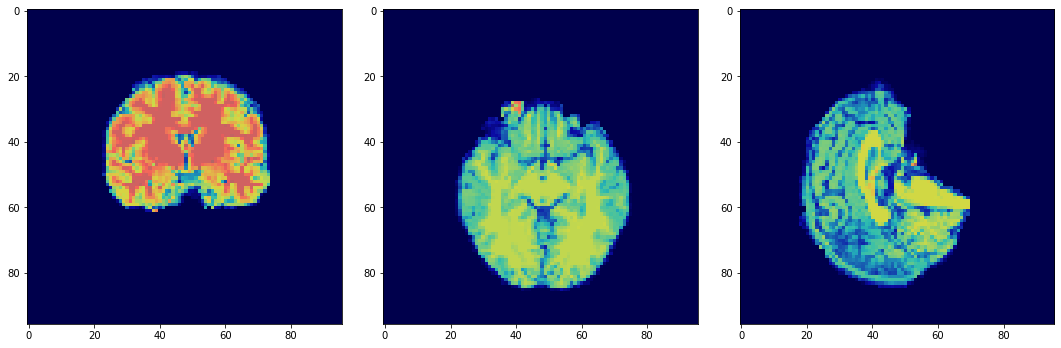

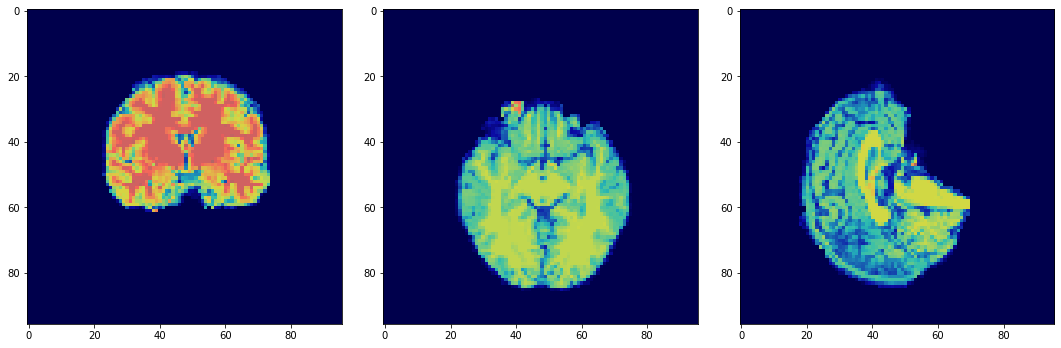

In [52]:
plot_vismap(resized_nifti, resized_nifti, masked=False,)

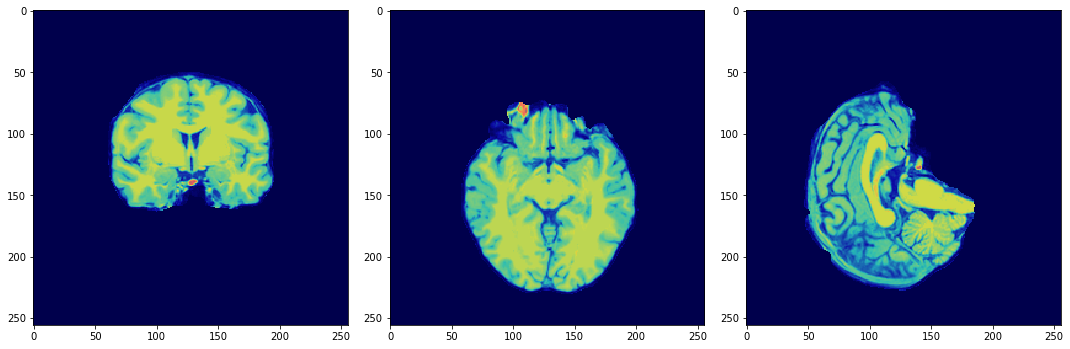

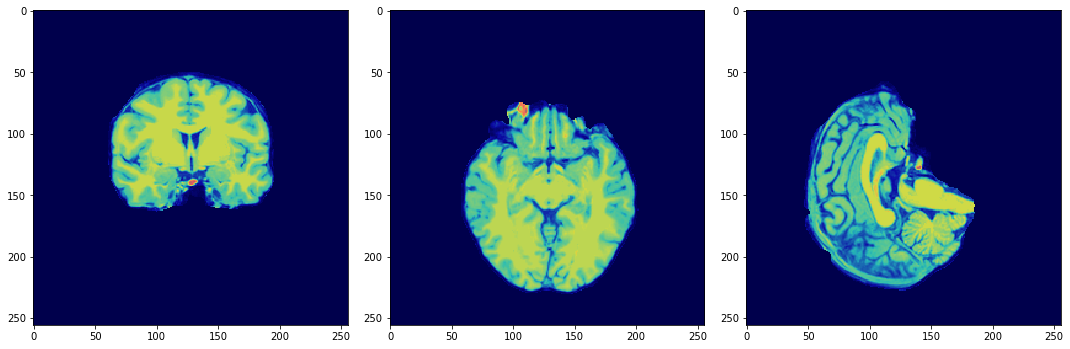

In [53]:
plot_vismap(nifti, nifti, slc=128, masked=False)

In [23]:
from scipy import resize
import numpy as np
from glob import glob

for fname in glob("../non_registered/npy/*.npy"):
    
    origin = np.load(fname, allow_pickle=True)
    if origin.shape == (96, 96, 96):
        pass
    else:
        resized = resize(origin, (96, 96, 96))
        np.save(fname, resized)

OSError: Failed to interpret file '../non_registered/npy/sub-OAS30852_ses-d2307_run-04_T1w.npy-brainmask.npy' as a pickle

In [13]:
type(_)

numpy.ndarray

In [59]:
from glob import glob
import numpy as np

np.load(glob("../non_registered/npy/*.npy")[0])

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [25]:
labels.to_csv("../non_registered/nifti/label.csv", index=False)

In [1]:
from sage.training.trainer import MRITrainer
from sage.config import load_config

cfg = load_config()

cfg.registration = "non_registered"

In [2]:
trainer = MRITrainer(cfg)

Use cuda:0 as a device.


[01/19/2022 18:25:41] INFO - sage.data.dataloader: Initialize dataset.
[01/19/2022 18:25:41] INFO - sage.data.dataloader: Initialize dataset.
[01/19/2022 18:25:41] INFO - sage.data.dataloader: Initialize dataset.


Output from encoder is 128.
Total Number of parameters: 905549
TOTAL TRAIN 1044 | VALID 262 | TEST 146
MIXED PRECISION:: True


In [4]:
batch = _

In [11]:
trainer.test_dataloader.dataset.configuration()[1].maxcut is None

True

In [61]:
import numpy as np
from sage.visualization.vistool import plot_vismap
from glob import glob
import matplotlib.pyplot as plt

sample_np_nonreg = np.load(sorted(glob("../non_registered/npy/*.npy"))[0])

In [60]:
sample_np = np.load(sorted(glob("../brainmask_mni/*.npy"))[0])

In [21]:
sample_np.dtype

dtype('float32')

In [20]:
sample_np_nonreg.dtype

dtype('float64')

(array([     0.,      0.,      0.,      0.,      0., 884736.,      0.,
             0.,      0.,      0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

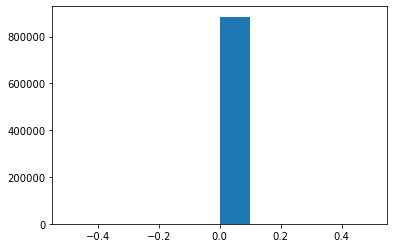

In [12]:
plt.hist(sample_np.flatten())

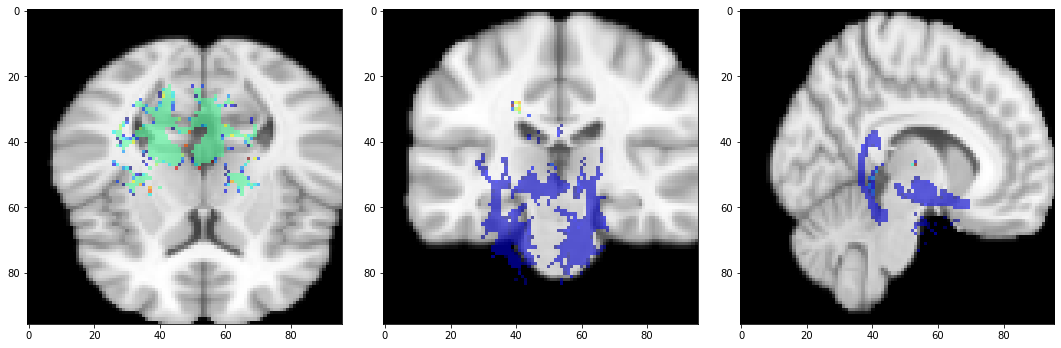

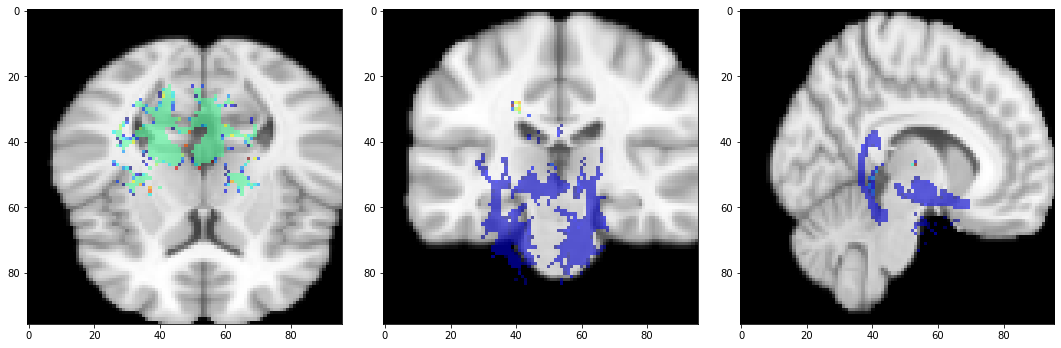

In [63]:
plot_vismap("template", sample_np_nonreg)